In [ ]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from shapely.geometry.polygon import Polygon
import json
import numpy as np
import re

# Datenimport

In einem separaten Jupyter-Notebook wird gezeigt, wie der Datensatz entsteht, beginnend beim Download der öffentlich zugänglichen Daten.

In [ ]:
df = pd.read_csv("data/krs_pkw_rug.csv",
                 dtype = {"krs_code": object},
                 index_col = "krs_code"
                )

Geodaten für die Umrisse der Kreise laden. Diese Daten liegen in einem für uns ungüstigen Koordinaten-Referenzsystem vor; das wird korrigiert.

In [ ]:
geo = gpd.read_file("download/Kreisgrenzen/vg2500_12-31.utm32s.shape/vg2500/VG2500_KRS.shp")
geo = geo[["AGS", "geometry"]]
geo = geo.rename({"AGS": "krs_code"}, axis = 1)
geo = geo.to_crs(epsg = "4236")

Wir packen Daten und Geodaten in einen Datenframe, denn Ordnung ist das halbe Leben.

In [ ]:
gdf = pd.merge(df, geo, on = "krs_code")
gdf = gpd.GeoDataFrame(gdf)
gdf = gdf.set_index("krs_code")
gdf.head()

# Ein Blick auf die abhängige Variable

Wir schauen uns auf der Karte an, wie hoch der Anteil stark motorisierter PKW in jedem Kreis ist. Dies ist nur ein Teil der verfügbaren Information, denn die Daten zur Motorisierung besitzen drei Kategorien. Im statistischen Modell weiter unten verwenden wir die gesamte Information.  
Die Karte erlaubt Zoom, per Maus lässt sich der Wert ablesen, Doppelklick setzt den Katenausschnitt zurück.

In [ ]:
fig = px.choropleth_mapbox(gdf,
                           geojson = gdf.geometry,
                           color = "cm3_over_1999_pct",
                           mapbox_style = "open-street-map",
                           locations = gdf.index,
                           opacity = 1,
                           hover_name = "name",
                           custom_data = ["pkw_gesamt"],
                           center={"lat":50.0,
                                   "lon":10.453},
                           zoom = 5.1 )
fig.update_traces(hovertemplate = "<b>%{hovertext}</b><br><br>Anteil der PKW mit Hubraum ab 2.000 cm³:<br>%{z:.2f} %<br>Registrierte PKW: %{customdata:.0f}<extra></extra>",
                  marker_line = dict(width = .5,
                                     color = "#000"),
                 )
fig.update_layout(height = 400,
                  width = 800,
                  coloraxis_colorbar_title = "%",
                  coloraxis_showscale = False,
                  margin = dict(t=0, r=0, b=0, l=0)
                 )
fig.update_mapboxes(pitch=45)
fig.show()

Die gleiche Variable betrachten wir oberfächlich visuell im Vergleich mit den beiden Prädiktorvariablen, die wir uns ausgesucht haben. Ob die eine oder die andere besser vorhersagt, wie stark die Menschen sich an einem Ort motorisieren, lässt sich hier informell und ungenau (dafür intuitiv) daran ablesen, ob die Farbverläufe von Karte zu Karte Parallelen aufweisen, d.h. ob die gleichen Regionen auf beiden Karten hell oder dunkel sind.

In [ ]:
fig = make_subplots(rows = 1, cols = 3,
                    specs = [[{"type": "choropleth"}, {"type": "choropleth"}, {"type": "choropleth"}]],
                    column_titles = ["Geländerauhheit", "Anteil antriebsstarker PKW", "Pro-Kopf-Einkommen"],
                    horizontal_spacing = 0.0025 )

fig.update_layout(margin = dict(t=25, r=0, b=0, l=0),
                  coloraxis_showscale = False,
                  autosize = True,
                  height = 400, width = 1100,
                  paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)"
                 )

column_hovertext = {"m_rugged":          "<b>%{customdata}</b><br>Rauhheit: %{z:.1f}<extra></extra>",
                    "cm3_over_1999_pct": "<b>%{customdata}</b><br>PKW ab 2.000cm³: %{z:.2f} %<extra></extra>",
                    "income":               "<b>%{customdata}</b><br>Einkommen: %{z:.0f} €<extra></extra>"
                   }

for i, this_column_hovertext in enumerate(column_hovertext.items()):
    column, hovertext = this_column_hovertext
    fig.add_trace(
        go.Choropleth(locations = gdf.index,
                      z = gdf[column].astype(float), # Data to be color-coded
                      geojson = json.loads(gdf[["geometry"]].to_json()),
                      showscale = False,
                      customdata = gdf.name,
                      hovertemplate = hovertext,
                      marker_line = {"width": .5,
                                     "color": "black"}
                      ),
        col = i+1, row = 1)
    
fig.update_geos(fitbounds="locations",
                visible = False,
                projection_type = "mercator")

Ob zwischen unseren beiden Prädiktoren und der Motorisierung eine Korrelation besteht, lässt sich auch über einen einfachen Scatterplot zeigen. In den beiden Tafeln steigen Rauhheit und Einkommen jeweils von links nach rechts an. Ein Zusammenhang mit der Motorisierung (y-Achse) zeigt sich in einer mehr oder weniger starken Tendenz der Punkte, zu einer Linie zu konvergieren. Spätestens hier deutet sich ein Unterschied zwischen Rauhheit und Einkommen an. Auch hier gibt die Berührung mit der Maus genaue Zahlen preis.

In [ ]:
fig = make_subplots(rows = 1, cols = 2,
                    column_titles = ("Geländerauhheit", "Haushaltseinkommen pro Kopf"),
                    horizontal_spacing = 0.0075,
                    shared_yaxes = True )

figA = go.Scatter(x = gdf.m_rugged,
                  y = gdf.cm3_over_1999_pct,
                  mode = "markers",
                  showlegend = False,
                  marker_opacity = .5)

figB = go.Scatter(x = gdf.income,
                  y = gdf.cm3_over_1999_pct,
                  mode = "markers",
                  showlegend = False,
                  marker_opacity = .5)

fig.add_trace(figA, row=1, col=1)
fig.add_trace(figB, row=1, col=2)

fig.update_traces(customdata = gdf.name)

fig.data[0].hovertemplate = "<b>%{customdata}</b><br>Rauhheit: %{x:.1f}<br>PKW ab 2.000cm³: %{y:.2f}<extra></extra>"
fig.data[1].hovertemplate = "<b>%{customdata}</b><br>Einkommen: %{x:.1f}<br>PKW ab 2.000cm³: %{y:.2f}<extra></extra>"

fig.update_layout(title = {"text": ""},
                  height = 400, width = 800,
                  margin = dict(t=25, r=5, b=5, l=5),
                  yaxis_ticks = None,
                  plot_bgcolor = "rgba(200,200,200,.3)",
                  paper_bgcolor = "rgba(0,0,0,0)",
                  xaxis_gridcolor = "rgba(0,0,0,0)",
                  xaxis2_gridcolor = "rgba(0,0,0,0)",
                  #xaxis_zeroline = False,
                  yaxis_gridcolor = "rgba(0,0,0,0)",
                  yaxis2_gridcolor = "rgba(0,0,0,0)",
                 )

fig.show()

# Statistisches Modell

Wir benutzen einige Lineare Modelle (genauer: Bayes'sche Generalized Linear Models), um die Fähigkeit der Variablen Rauhheit und Einkommen zu quantifizieren, vorherzusagen, wie sich die Menschen in den verschiedenen Kreisen motorisieren.
Diese Art der Modellierung setzen wir in R um.

In [ ]:
%load_ext rpy2.ipython
import rpy2.robjects as robjects

In [ ]:
%%R
library(brms)
library(tidyverse)
library(tidybayes)

In [ ]:
%%R -i df

# prepare data set:
df <- tibble(df) |>
    transmute(
        id = 1:nrow(df),
        name,
        max_cm3_1399,
        max_cm3_1999,
        cm3_over_1999,
        income,
        income_scaled = scale(income),
        m_rugged,
        m_rugged_scaled = scale(m_rugged),
        size = max_cm3_1399 + max_cm3_1999 + cm3_over_1999
    )
df

In [ ]:
%%R

# select priors, fit model:
cbind2 <- cbind
prior <- prior(normal(0, 10), "b" ) +
         prior(cauchy(0, 1), "Intercept")

model_ir <- brm(bf( cbind2(max_cm3_1399, max_cm3_1999, cm3_over_1999) | trials(size) ~ income_scaled * m_rugged_scaled + (1 | id) ),
                data = df,
                family = multinomial(),
                prior = prior,
                iter = 5500, warmup = 500, chains = 6, cores = 6,
                file = "model_ir.rds")

## Modellvorhersagen

Wir haben zwei Prädiktoren (Geländerauhheit und Einkommen), die sich auf das Ergebnis auswirken. Ein dreidimensionaler Plot könnte hier theoretisch passen, aber auch wenn diese Art der Darstellung beliebt ist und Informationsreichtum suggeriert, sie ist sehr ungenau. Wir helfen uns stattdessen mit dem "Triptychon": Wir schauen uns die Auswirkung einer Variable kontinuierlich an, während wir die andere Variable niedrig, mittel oder hoch ansetzen.

### Triptychon

In [ ]:
%%R
# temp: test prediction with group effects:
temp_simdat <- tibble(
    income_scaled = 0,
    m_rugged_scaled = 0,
    size = 1e5,
    id = "doesn't matter"
)

temp_simdat |>
    add_predicted_draws(model_ir,
                        allow_new_levels = TRUE)

In [ ]:
%%R

# get posterior predictions:
simdat <- expand_grid(
    income_scaled = c(-2, 0, 2),
    m_rugged_scaled = seq(-2, 2, length.out = 10),
    size = 1e5,
    id = "doesn't matter"
)

post_m1 <- simdat |>
    # raw model predictions: counts of cars (as in the data):
    add_predicted_draws(model_ir,
                        allow_new_levels = TRUE) |>
    mean_qi(.width = c(.95, .50)) |>
    mutate(.category = as.character(.category),
           .row = NULL,
           income = income_scaled * attr(df$income_scaled, "scaled:scale") + attr(df$income_scaled, "scaled:center"),
           m_rugged = m_rugged_scaled * attr(df$m_rugged_scaled, "scaled:scale") + attr(df$m_rugged_scaled, "scaled:center")
          ) |>
    # shape to [income x rugged x width , motor x stat]:
    pivot_wider(names_from = .category,
                values_from = .prediction:.upper) |>
    transmute(
        income_scaled,
        m_rugged_scaled,
        width = .width,
        low_ratio = .prediction_max_cm3_1399  / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        low_diff_lower = (.prediction_max_cm3_1399 - .lower_max_cm3_1399) / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        low_diff_upper = (.upper_max_cm3_1399 - .prediction_max_cm3_1399) / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        mid_ratio = .prediction_max_cm3_1999  / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        mid_diff_lower = (.prediction_max_cm3_1999 - .lower_max_cm3_1999) / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        mid_diff_upper = (.upper_max_cm3_1999 - .prediction_max_cm3_1999) / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        hi_ratio  = .prediction_cm3_over_1999 / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        hi_diff_lower = (.prediction_cm3_over_1999 - .lower_cm3_over_1999) / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
        hi_diff_upper = (.upper_cm3_over_1999 - .prediction_cm3_over_1999) / (.prediction_max_cm3_1399 + .prediction_max_cm3_1999 + .prediction_cm3_over_1999),
                
        # stack proportions to add to 1:
        low_ratio = low_ratio,
        low_lower = low_ratio - low_diff_lower,
        low_upper = low_ratio + low_diff_upper,
        mid_ratio = mid_ratio + low_ratio,
        mid_lower = mid_ratio - mid_diff_lower,
        mid_upper = mid_ratio + mid_diff_upper,
        hi_ratio  = hi_ratio  + mid_ratio,
        hi_lower  = hi_ratio  - hi_diff_lower,
        hi_upper  = hi_ratio  + hi_diff_upper,
    ) |>
    
        # remove intermediate columns:
        select(income_scaled, m_rugged_scaled, width,
               low_ratio, low_lower, low_upper,
               mid_ratio, mid_lower, mid_upper,
               hi_ratio, hi_lower, hi_upper) |>
    # shape to [income x rugged x width x motor x stat , ]:
    pivot_longer(cols = low_ratio:hi_upper,
                 names_sep = "_",
                 names_to = c("motor", "stat")) |>
    # shape to [income x rugged x width x motor, stat]:
    pivot_wider(names_from = stat,
                values_from = value)
post_m1

In [ ]:
%%R
colnames_post <- colnames(post_m1)

In [463]:
post_m1 = pd.DataFrame( robjects.globalenv["post_m1"] ).transpose()
post_m1.columns = robjects.globalenv["colnames_post"]
post_m1

,income_scaled,m_rugged_scaled,width,motor,ratio,lower,upper
0,-2.0,-2.0,0.95,low,0.412738,0.353482,0.465433
1,-2.0,-2.0,0.95,mid,0.880171,0.839313,0.928818
2,-2.0,-2.0,0.95,hi,1.0,0.97072,1.029083
3,-2.0,-1.555556,0.95,low,0.410667,0.35168,0.462302
4,-2.0,-1.555556,0.95,mid,0.88197,0.841746,0.928758
...,...,...,...,...,...,...,...
175,2.0,1.555556,0.5,mid,0.832468,0.816999,0.846361
176,2.0,1.555556,0.5,hi,1.0,0.988746,1.011808
177,2.0,2.0,0.5,low,0.342254,0.32581,0.360123
178,2.0,2.0,0.5,mid,0.832859,0.817232,0.847007


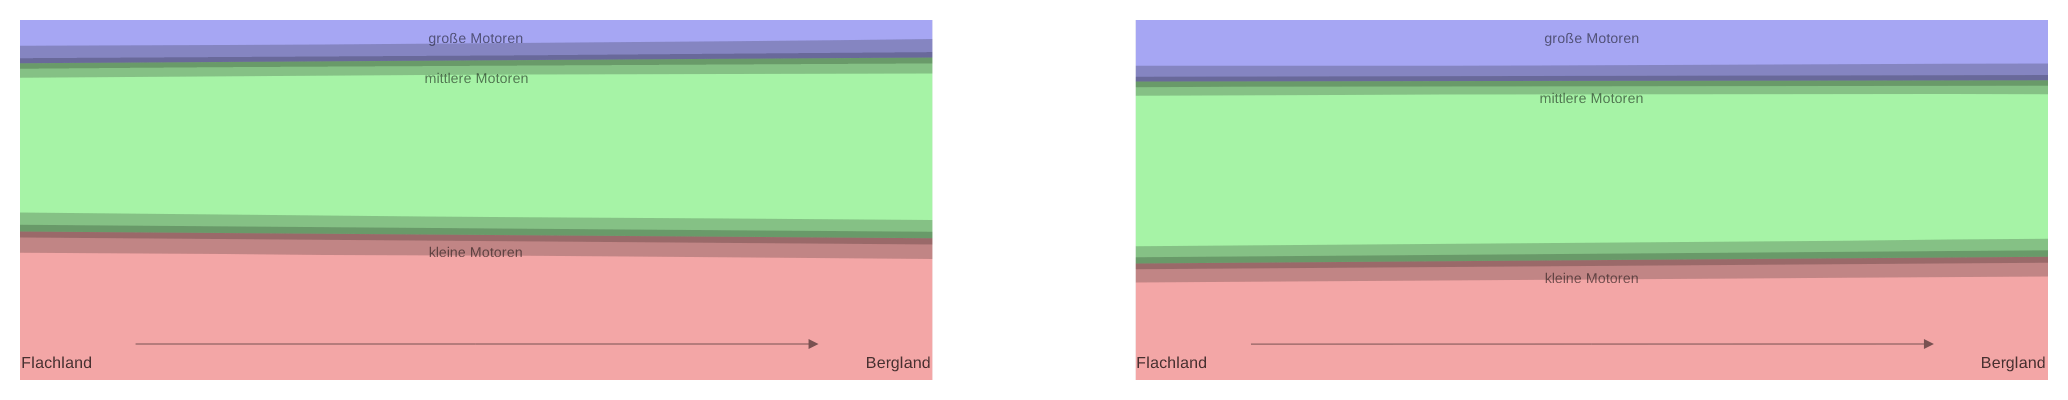

In [492]:
colors = ["rgba(255,0,0,.3)", "rgba(0,255,0,.3)", "rgba(0,0,255,.3)"]
motors = ["low", "mid", "hi"]
annotations = ["kleine Motoren", "mittlere Motoren", "große Motoren"]
incomes = [-2.0, 2.0]
widths = [.95, .5]

fig = make_subplots(rows = 1, cols = 2)

for plotcolumn, income_scaled in zip([1,2], incomes):
    # filter to df for each panel:
    post_m1_thispanel = post_m1.loc[
        (post_m1.income_scaled == income_scaled)
    ]

    for color, motor, annotation in zip(colors, motors, annotations):
        # filter to df for each trace:
        post_m1_thistrace = post_m1_thispanel.loc[
            (post_m1.motor == motor) &
            (post_m1.width == .95) # arbitrary; need any 1 width to draw mean
        ]
        this_annotation_y = np.mean(post_m1_thistrace.ratio) - .05

        # the area trace:
        fig.add_trace(
            go.Scatter(
                x = post_m1_thistrace.m_rugged_scaled,
                y = post_m1_thistrace.ratio,
                mode = "lines",
                fill = "tonexty",
                line = dict(width = 0),
                fillcolor = color,
                showlegend = False,
            ), col = plotcolumn, row = 1 )
        
        # motorization label:
        fig.add_annotation(x = .0,
                           y = this_annotation_y,
                           text = annotation,
                           xref = "x",
                           xanchor = "center",
                           showarrow = False,
                           font = dict(color = "rgba(0,0,0,.5)",
                                       size = 14),
                           row = 1, col = plotcolumn
                          )

    # arrow:
    fig.add_annotation(x = 1.5, xref = "x",
                       y = .1, yref = "y",
                       ax = -1.5, axref = "x"+str(plotcolumn),
                       ay = .1, ayref = "y",
                       text = "", arrowhead = 2, arrowcolor = "rgba(0,0,0,.5)", arrowsize = 2,
                       row = 1, col = plotcolumn
                      )
    
    # Bergland & Flachland:
    fig.add_annotation(x = 2, y = .05, showarrow = False,
                       text = "Bergland", xanchor = "right",
                       font = dict(color = "rgba(0,0,0,.7)", size = 16),
                       row = 1, col = plotcolumn
                      )
    fig.add_annotation(x = -2, y = .05, showarrow = False,
                       text = "Flachland", xanchor = "left",
                       font = dict(color = "rgba(0,0,0,.7)", size = 16),
                       row = 1, col = plotcolumn
                      )

    # depict uncertainty:
    for width in widths:
    
        for motor in ["low", "mid"]:

            post_m1_uncertainty = post_m1_thispanel.loc[(post_m1_thispanel.width == width) &
                                                        (post_m1_thispanel.motor == motor)]

            fig.add_trace(
                go.Scatter(
                    x = pd.concat([post_m1_uncertainty.m_rugged_scaled,
                                   post_m1_uncertainty.m_rugged_scaled[::-1]]),
                    y = pd.concat([post_m1_uncertainty.upper,
                                   post_m1_uncertainty.lower[::-1]]),
                    mode = "lines",
                    line = dict(width = 0),
                    fill = "toself",
                    fillcolor = "rgba(0,0,0,.2)",
                    showlegend = False
                ),
                row = 1, col = plotcolumn
            )

                  
    
fig.update_layout(height = 400,
                  width = 800,
                  xaxis = dict(tickvals = [],
                               zeroline = False,
                               gridcolor = "rgba(0,0,0,0)"
                              ),
                  xaxis2 = dict(tickvals = [],
                               zeroline = False,
                               gridcolor = "rgba(0,0,0,0)"
                              ),
                  yaxis = dict(tickvals = [],
                               range = [0,1],
                               zeroline = False,
                               gridcolor = "rgba(0,0,0,0)"
                              ),
                  yaxis2 = dict(tickvals = [],
                               range = [0,1],
                               zeroline = False,
                               gridcolor = "rgba(0,0,0,0)"
                              ),
                  margin = dict(t=20, r=20, b=20, l=20),
                  plot_bgcolor = "rgba(200,200,200,.3)",
                  paper_bgcolor = "rgba(0,0,0,0)",
                  xaxis_gridcolor = "rgba(0,0,0,0)",
                 )


    
fig.show()

In [ ]:
print(fig)

In [ ]:
df = px.data.gapminder()
df